# Lab 3. Recommendation system

## Setting

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (20, 6)})

In [2]:
from tqdm import tqdm

## Probabilitics Matrix Factorization (PMF)

Given a non-negative valued $(n\times m)$ matrix $X$ with missing values we are going to find approximate factorization

$$X \approx U^T V, \qquad U\in \mathbb{R}^{d\times n}, V\in \mathbb{R}^{d\times m}$$

using loss function

$$L = \frac 12 \left(\frac1{\sigma^2}\sum_{(i, j)\in \Omega} ||X_{ij} - U_i^TV_j||^2 + \lambda \sum_{i=1}^n ||U_i||^2 + \lambda \sum_{j=1}^m ||V_j||^2  \right) $$

We have the following equations for $U$ and $V$ which are minimize the loss function:

$$U_i = \left(\lambda\sigma^2 I + \sum_{j\in\Omega_{U_i}} V_jV_j^T\right)^{-1} \left(\sum_{j\in\Omega_{U_i}} X_{ij} V_j\right) $$

$$V_j = \left(\lambda\sigma^2 I + \sum_{i\in\Omega_{V_j}} U_jU_j^T\right)^{-1} \left(\sum_{i\in\Omega_{V_j}} X_{ij} U_j\right) $$

So we can use them to execute iterative solution search by alternating adjusting $U$ and $V$.

In [3]:
class PMF:
    U = None
    V = None
    
    def __init__(self, l, s, eps=0.1, max_iter=100):
        self.l = l
        self.s = s
        self.eps = 0.1
        self.max_iter = max_iter
        
    def _loss(self, X):
        if X is None:
            return np.nan
        
        UV = self.U.T @ self.V
        X_UV = X[X > 0] - UV[X > 0]
        
        L = 0.5 * ((X_UV ** 2).sum() / self.s**2 + self.l * (self.U**2).sum() + self.l * (self.V**2).sum())
        
        return L
        
    def _update_parameters(self, X, d):
        n = self.U.shape[1]
        m = self.V.shape[1]
        
        for i in range(n):
            Vj = self.V[:, X[i, :] > 0]
            self.U[:, i] = np.linalg.inv(self.l * self.s **2 * np.identity(d) + Vj @ Vj.T) @ (X[i, X[i, :] > 0] @ Vj.T)
            
        for j in range(m):
            Ui = self.U[:, X[:, j] > 0]
            self.V[:, j] = np.linalg.inv(self.l * self.s **2 * np.identity(d) + Ui @ Ui.T) @ (X[X[:, j] > 0, j] @ Ui.T)
            
        
    def fit(self, X, d, X_test = None):
        X[np.isnan(X)] = 0
        
        n, m = X.shape
        self.U = np.random.normal(0, 1/self.l, size=(d, n))
        self.V = np.random.normal(0, 1/self.l, size=(d, m))
        
        loss = []
        loss.append(np.inf)
        loss.append(self._loss(X))
        
        loss_test = []
        loss_test.append(np.inf)
        loss_test.append(self._loss(X_test))
        
        for i in tqdm(range(self.max_iter)):
            if abs(loss[-1] - loss[-2]) < self.eps :
                print("Done")
                break
            self._update_parameters(X, d)
            loss.append(self._loss(X))
            loss_test.append(self._loss(X_test))
            
        return loss, loss_test
        
    def transform(self):
        return self.U.T @ self.V 
    
    def factors(self):
        return self.U, self.V

In [4]:
x = np.random.uniform(0, 10, size=(10, 15)) 
x[x < 5] = np.nan 
x = np.around(x+1)

In [5]:
x

array([[ 8., nan,  7.,  6.,  9.,  7., nan,  8., nan, nan, 10., nan, nan,
        nan, nan],
       [ 9., nan,  6., nan, nan, nan, nan, 11., nan, nan, nan,  6., nan,
         9., nan],
       [nan,  7., nan,  7.,  8., nan,  7., nan,  9.,  7.,  9.,  7., nan,
        nan, nan],
       [nan,  8., 11., 11., nan,  9., nan, nan, nan, nan,  9.,  9., nan,
        nan,  8.],
       [ 6., nan, 10.,  8., nan, nan, 10., 10.,  9., nan, nan, nan, 10.,
         9., nan],
       [ 8.,  9., nan,  8.,  9., nan, nan, nan, nan,  7.,  9., nan, nan,
        nan, nan],
       [nan,  6., nan, 10., nan, nan, nan, nan, nan, nan, nan,  6., nan,
        nan, nan],
       [10., nan, nan, nan, nan, nan, nan, nan, 10.,  9.,  6., nan, nan,
        nan, nan],
       [nan, 10., nan, nan, nan, 10., nan, nan, 10., nan,  7., nan, nan,
        11., nan],
       [nan, nan,  7., nan, nan, nan, nan,  8.,  7., nan, nan,  7.,  7.,
        nan, nan]])

In [6]:
pmf = PMF(1, 1, eps=0.1)

In [7]:
loss, _ = pmf.fit(x, d=5)

 24%|█████████████████                                                      | 24/100 [00:00<00:00, 526.58it/s]

Done


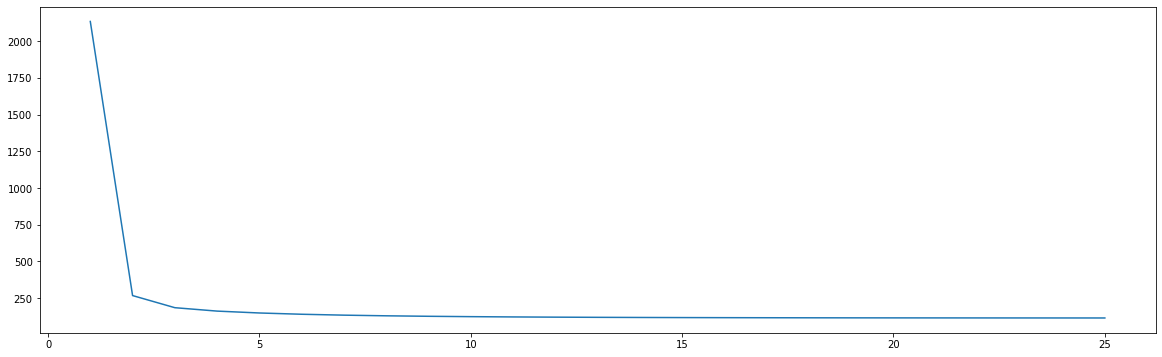

In [8]:
plt.plot(loss)
plt.show()

In [9]:
x[np.isnan(x)] = 0
((pmf.transform() - x) ** 2).mean()

32.388472037852665

## Loading data

Firstly books csv was fixed, since originally lots of rows had additional `;` in the books title

In [10]:
ratings = pd.read_csv('data/BX-Book-Ratings.csv', sep=';')
books = pd.read_csv('data/BX-Books.csv', sep=';', low_memory=False)
users = pd.read_csv('data/BX-Users.csv', sep=';')

In [11]:
ratings["ISBN"] = ratings["ISBN"].str.upper()
ratings

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [12]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [13]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


## Prepare data 

### Decrease dataset size

In [14]:
m = len(set(ratings['User-ID']))
n = len(set(ratings['ISBN'])) 
m, n

(105283, 340218)

To just create a matrix with users and books and int64 entries we would need approximetely 

$$10^5 \cdot 3\cdot 10^5 \cdot 2^6 \text{ bits} = 3\cdot 10^{10}\cdot 2^6 \text{ bits} = \frac{3\cdot 2^6\cdot 10^{10}}{8\cdot 10^9} \text{ GB} = 240 \text{GB}$$

Of course I don't have such amount of RAM on my laptop, so we are going to work only with some part this theoretical matrix. Lab instruction suggests to decrease matrix to have at most $1.5 \cdot 10^6$ elements, i.e. needed amount of RAM would be 

$$\frac{1.5 \cdot 10^6 \cdot 2^6}{8\cdot 10^9} \text{ GB} = 12\cdot 10^{-3} \text{ GB} = 12 \text{ MB}$$

But then we have a trade of: what data we should drop --- more users, or more books? If we consider less users, we will have less users and more information about each of them. Otherwise, if we consider less books, we will have more users, but less information about each of them. 

Lets count how many information about each book and each user we have initially 

In [15]:
books_stat = ratings[['ISBN', 'Book-Rating']].groupby(by=['ISBN']).count()\
    .rename(columns={'Book-Rating': 'rated_by'}).sort_values(by='rated_by', ascending=False)
books_stat

,rated_by
ISBN,
0971880107,2502
0316666343,1295
0385504209,883
0060928336,732
0312195516,723
...,...
0671663267,1
0671663410,1
0671663550,1


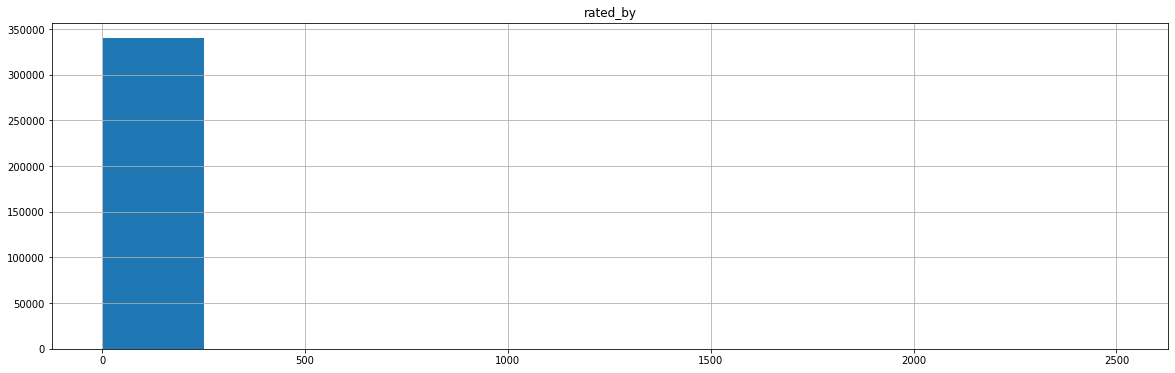

In [16]:
books_stat.hist()
plt.show()

In [17]:
(books_stat >= 100).sum()

rated_by    731
dtype: int64

So there are only 731 books which were rated by more than 100 users. Lets remain only those

In [18]:
users_stat = ratings[['User-ID', 'ISBN']].groupby(by=['User-ID']).count()\
    .rename(columns={'ISBN': 'books_rated'}).sort_values(by='books_rated', ascending=False)
users_stat

,books_rated
User-ID,
11676,13602
198711,7550
153662,6109
98391,5891
35859,5850
...,...
118579,1
118576,1
118574,1


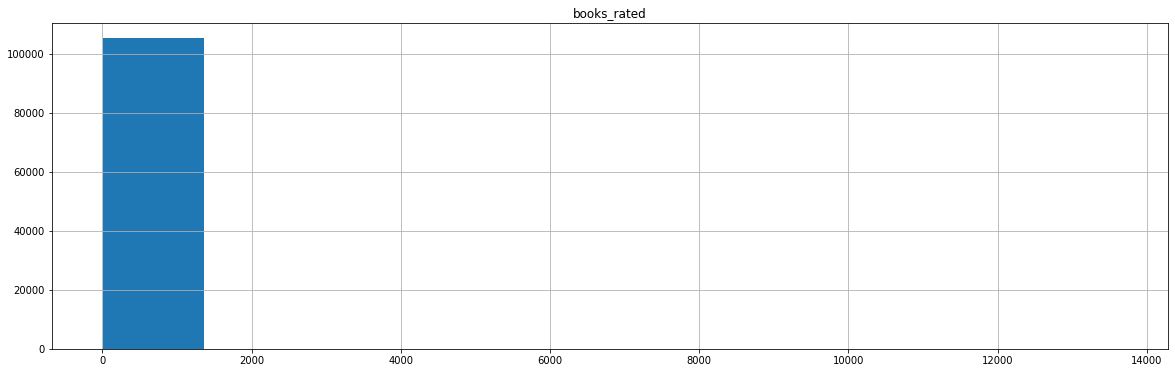

In [19]:
users_stat.hist()
plt.show()

In [20]:
(users_stat['books_rated'] >= 100).sum()

1847

Again there are relatively small amount of active users with more than 100 rated books, so we can just choose only them

Then we will have $1847 \times 731 = 1350157 < 1.5\cdot 10^6$ entries in the matrix

In [21]:
1847 * 731

1350157

In [22]:
books_chosen = books_stat[books_stat['rated_by'] >= 100].index
users_chosen = users_stat[users_stat['books_rated'] >= 100].index
ratings_chosen = ratings[ratings['ISBN'].isin(books_chosen) & ratings['User-ID'].isin(users_chosen)]
ratings_chosen

,User-ID,ISBN,Book-Rating
413,276925,002542730X,10
426,276925,0316666343,0
429,276925,0385504209,8
453,276925,0804106304,0
457,276925,0971880107,0
...,...,...,...
1149553,276680,0446670251,0
1149564,276680,0452283205,7
1149577,276680,0679731725,0
1149581,276680,0679781587,9


In [23]:
ratings_chosen.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65934 entries, 413 to 1149592
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   User-ID      65934 non-null  int64 
 1   ISBN         65934 non-null  object
 2   Book-Rating  65934 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 5.7 MB


### Create matrix

We are going to split data for train and test parts to validate our recommendation system later

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
ratings_train, ratings_test = train_test_split(ratings_chosen, shuffle=True, train_size=0.8) 

In [26]:
ratings_train.shape, ratings_test.shape

((52747, 3), (13187, 3))

In [27]:
X = pd.DataFrame(index=users_chosen, columns=books_chosen, dtype=float)
X_test = pd.DataFrame(index=users_chosen, columns=books_chosen, dtype=float)

In [28]:
for i, row in ratings_train.iterrows():
    X.loc[row['User-ID'], row['ISBN']] = row['Book-Rating'] + 1
    
for i, row in ratings_test.iterrows():
    X_test.loc[row['User-ID'], row['ISBN']] = row['Book-Rating'] + 1

In [29]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1847 entries, 11676 to 160410
Columns: 731 entries, 0971880107 to 0449203794
dtypes: float64(731)
memory usage: 10.4 MB


In [30]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1847 entries, 11676 to 160410
Columns: 731 entries, 0971880107 to 0449203794
dtypes: float64(731)
memory usage: 10.4 MB


In [31]:
X.size

1350157

## Recommendation

In [32]:
from sklearn.metrics import mean_squared_error as mse

In [38]:
pmf = PMF(1, 1, eps=100000, max_iter=100)

100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.58it/s]


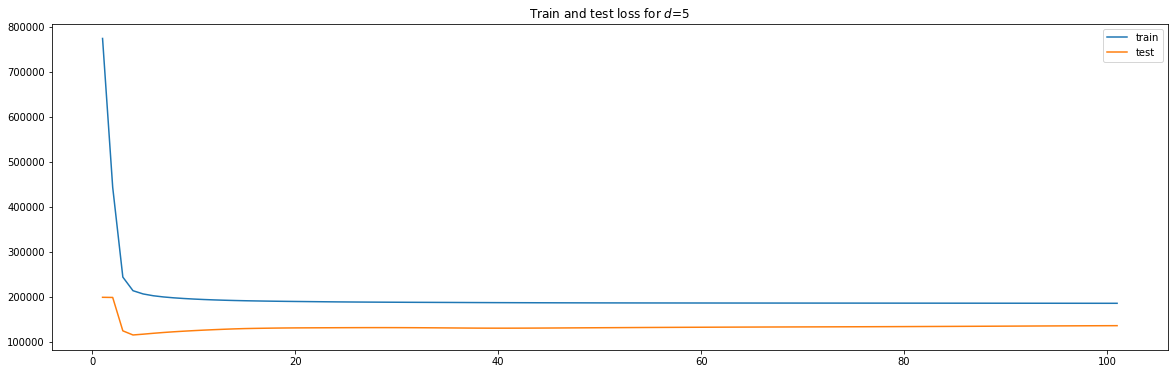

100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.05it/s]


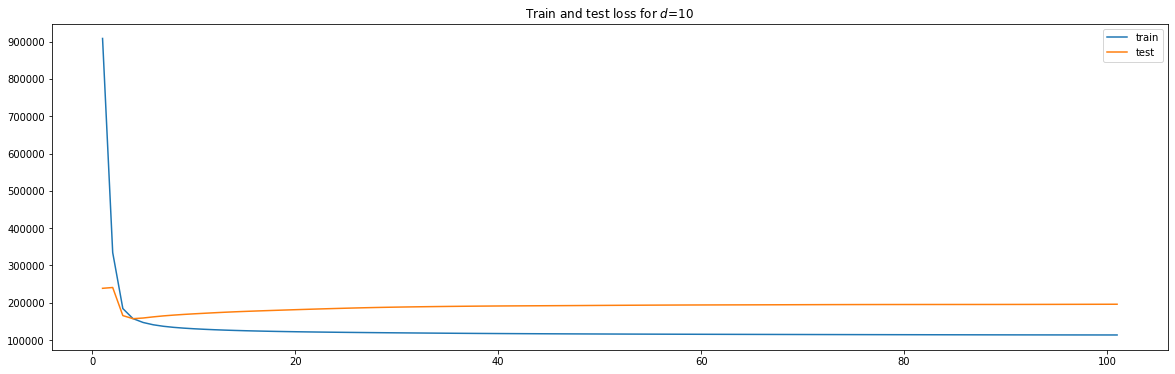

100%|███████████████████████████████████████████████████████████████████████| 100/100 [06:28<00:00,  3.89s/it]


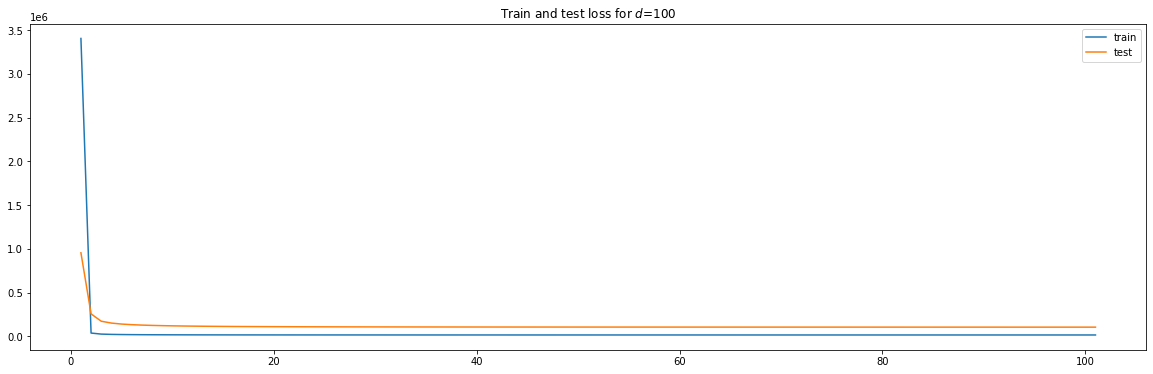

In [40]:
# ds = [5, 10, 100, 200, 500]
ds = [5, 10, 100]
metrics = []
for d in ds:
    loss_tr, loss_test = pmf.fit(X.values, d, X_test.values)
    
    Y = pmf.transform()
    
    mse_tr = mse(X.values[X > 0], Y[X > 0])
    mse_test = mse(X_test.values[X_test > 0], Y[X_test > 0])
    
    metrics.append({
        'd': d,
        'mse_train': mse_tr,
        'mse_test': mse_test
    })
        
    plt.title(fr"Train and test loss for $d$={d}")
    plt.plot(loss_tr, label='train')
    plt.plot(loss_test, label='test')
    plt.legend()
    plt.show()

In [41]:
metrics_df = pd.DataFrame(metrics)
metrics_df

,d,mse_train,mse_test
0,5,6.583621,18.793774
1,10,3.607609,26.925324
2,100,0.007982,13.575665
